In [1]:
import math
import numpy
from matplotlib import pyplot
%matplotlib inline

# Study of Pressure Distribution on NACA 4415 Airfoil due to External flap.

### Introduction

From Wright brothers first flight to Modern planes, Aircraft design has taken huge steps in advancement. Yet, all modern planes 
use the same basic wing design when it comes to providing lift and maneuverability. 
Basically, The shape of an airfoil is rounded on the top and flat at the bottom. when the air passes over the wing the air accelarates creting an area of low pressure. This low pressure creates a lift for a flight to take off.

<img src="./resources/lift.gif">

Lift generated by wing depends on the shape of an airfoil, wing are and velocity. During takeoff and landing the velocity of airplanes is low. 
#### so,how to increase the velocity?
To increase the velocity, the area of wing is increased and shape of the airfoil is also altered by adding some moving parts are attatched at the leading and tailing edges of the wing.
The moving part at the leading edge is a Slat and the one at the tailing edge is a Flap.

<img src="./resources/lift-v.gif">  <img src="./resources/lift-p.gif">

#### What flaps do?
They play a major role during take off and while landing.

Take off:
On extending the flap partially, the camber of the wing increases and this rises the maximum lift coeficient a wing can generate. This allows the aircraft to generate lift at a lower speed, reduce stailing speeds. 
<img src="./resources/Picture1.jpg">
###### Time to Land.

Landing:
similarly on extending the flap fully, high lift and drag is produced. This allows steeper and slower approach to landing site.   


#### Types of Flaps:
There are different types flaps:
Plain Flap,
Split flap,
Slotted flap
Fowler flap
Funkers flap
Gouge flap
Fairey- Youngman flap
Zap flap
Krueger flap
Gurney flap

<img src="./resources/main-qimg-d104c68450b79fd99f6a51d608fd8e5b.gif">


### Flap considered for this study : Junkers Flap

Junkers flap:
It is invented Germany in 1920s by O.Mader Junkers. The flap was designed to decrease take off and landing distance, as well as increase roll responsiveness in flight.
<img src="junkers-flap-retracted.jpg">
###### Junkers operation
It is a slotted plain flap, fixed below the trailing edge of the wing.So, the gap between the airfoil and flap allows airflow to pass between the wing and flap. Due to this increase in airflow, there is a significant increase in lift even at slow speeds.

<img src="./resources/junkers-flap-retracted.jpg">


##### Time to start the Simulations
To begin, Lets import two NACA 4415airfoil geometry from Airfoil Tools. 
one for Main airfoil and the other one for Flap foil.


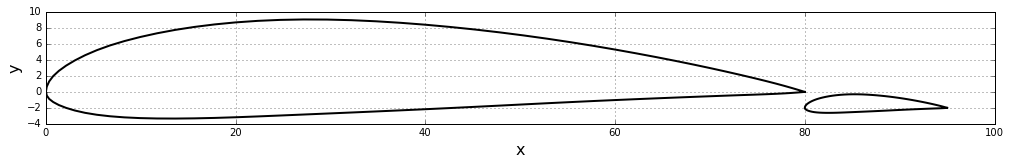

In [2]:
# reads of the geometry from a data file
with open ('./resources/naca4415-il.csv') as file_name:
    x_ends, y_ends = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    

with open ('./resources/naca4415flap-il (1).csv') as file_name:
    xf, yf = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    
xf = xf + 80
yf = yf - 2
    
# plots the geometry
%matplotlib inline
#size = 1
pyplot.figure(figsize=(17,2))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_ends, y_ends, xf, yf, color='k', linestyle='-', linewidth=2);

Got our NACA 4415 Airfoil and Flap geomentry!

Now, we try to rotate the flap with an angle.

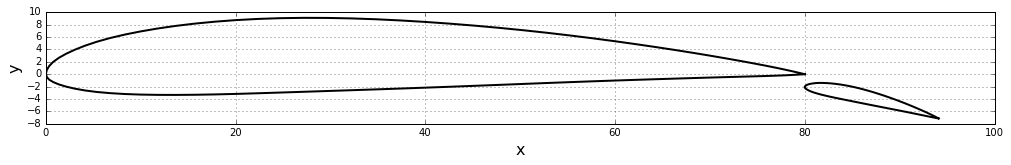

In [3]:
# reads of the geometry from a data file
with open ('./resources/naca4415-il.csv') as file_name:
    x_ends, y_ends = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    

with open ('./resources/naca4415flap-il (1).csv') as file_name:
    xf, yf = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

delta = (20.*math.pi)/180

for i in range(numpy.size(xf)):
    r = math.sqrt(xf[i]**2+yf[i]**2)
    theta_r = math.atan2(yf[i],xf[i])
    theta_r = theta_r-delta
    xf[i] = r*math.cos(theta_r)
    yf[i] = r*math.sin(theta_r)
    
xf = xf + 80
yf = yf - 2
    
# plots the geometry
%matplotlib inline
#size = 1
pyplot.figure(figsize=(17,2))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_ends, y_ends, xf, yf, color='k', linestyle='-', linewidth=2);

### Discretiziation of Airfoils into panels

The whole geomentry is discretized into panels. Each panels is defined by its starting and ending point, its strength and its orientation.

<img src="./resources/panelSketch.png">


In [17]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Initializes the panel.
        
        Arguments
        ---------
        xa, ya -- coordinates of the first end-point of the panel.
        xb, yb -- coordinates of the second end-point of the panel.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2            # collocation point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.n = [ math.cos(self.beta), math.sin(self.beta)]
        self.t = [-math.sin(self.beta), math.cos(self.beta)]
        
        self.kappa = 1                              # doublet strength
        self.vt = 0                                 # tangential velocity
        self.cp = 0                                 # pressure coefficient

This function can be used to call desired number of Panels

#### Discretization for NACA 4415 Main Airfoil

In [5]:
N_panels = 96                                      # number of panels desired
x_ends = numpy.delete(x_ends,[1,N_panels-1])       # delete 2nd and 2nd to last points to merge panels
y_ends = numpy.delete(y_ends,[1,N_panels-1])
N_panels = N_panels - 2
# define the panels
panels = numpy.empty(N_panels+1, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
panels[-1] = Panel(x_ends[0], y_ends[0], x_ends[0]+1000, y_ends[0])


#### Discretization for NACA 4415 Flap Airfoil

In [6]:
Nfpanels = 96                              # number of panels desired
xf = numpy.delete(xf,[1,Nfpanels-1])       # delete 2nd and 2nd to last points to merge panels
yf = numpy.delete(yf,[1,Nfpanels-1])
Nfpanels = Nfpanels - 2

# define the panels
panelsf = numpy.empty(Nfpanels+1, dtype=object)
for i in range(Nfpanels):
    panelsf[i] = Panel(xf[i], yf[i], xf[i+1], yf[i+1])
panelsf[-1] = Panel(xf[0], yf[0], xf[0]+1000, yf[0])


Lets check, the discretized airfoil and Flap by plotting them. 

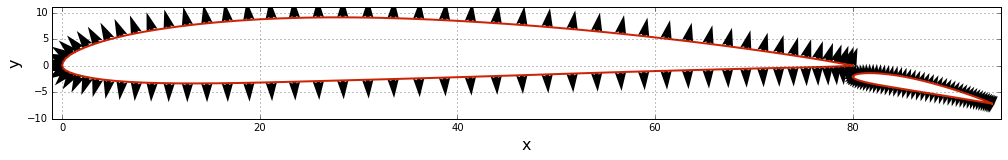

In [18]:
# plot the Main airfoil panels
#size = 6
pyplot.figure(figsize=(17,2))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2)
pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], [p.n[0] for p in panels], [p.n[1] for p in panels],
              scale=50, width=0.005)

# Plot for Flap Airfoil panels
pyplot.plot(xf, yf, color='#CD2305', linestyle='-', linewidth=2)
pyplot.quiver([p.xc for p in panelsf], [p.yc for p in panelsf], [p.n[0] for p in panelsf], [p.n[1] for p in panelsf],
              scale=100, width=0.005)

pyplot.xlim(-1,95)
pyplot.ylim(-10,11);



In [8]:
Uinf = 1.0                         # free-stream velocity
alpha = 0.0*math.pi/180            # angle of attack

#### Constant-Strength Doublet method
This is one of the two dimensional method which can be used to calculate the flow over thick lifting airfoils. 
In this method, wake panel has to be specified. The elements have strentgh 'K', which is calculated and extends upto infinity.
Practically, the far prtion of wake will not have any influence of vortex and can be placed far downstream.

<img src="./resources/12.png ">

Each doublet induces a velocity potential on every collocation point.so we calculate the induced velocites by using these formulas.
u_p = (−k)/2𝜋[𝑧/((𝑥−𝑥1)**2+z**2)  − z/((𝑥−𝑥2)**2+z**2)]

v_p = (k)/2𝜋[(𝑥−𝑥1)/((𝑥−𝑥1)**2+z**2)  − (𝑥−𝑥2)/((𝑥−𝑥2)**2+z**2)]

but these velocities components are in global coordinates, so they have transformed into local coordinates.

<img src="./resources/Picture2.png">


In [9]:
def get_doublet_panel_velocity(p,x,y):
    """Evaluates the velocity components induced at coordinates (x,y) by a panel p.
    
    Arguments
    ---------
    p -- panel from which the velocity is induced
    x -- x-coordinate in global frame
    y -- y-coordinate in global frame
    
    Returns
    -------
    (u,v)-components of velocity at (x,y)
    """
    
    x_p =  math.sin(p.beta)*(x-p.xb) - math.cos(p.beta)*(y-p.yb)
    y_p =  math.cos(p.beta)*(x-p.xb) + math.sin(p.beta)*(y-p.yb)
    
    u_p = -p.kappa/(2*math.pi)*(y_p/(x_p**2+y_p**2) - y_p/((x_p-p.length)**2+y_p**2))
    v_p =  p.kappa/(2*math.pi)*(x_p/(x_p**2+y_p**2) - (x_p-p.length)/((x_p-p.length)**2+y_p**2))
    
    u =  math.sin(p.beta)*u_p + math.cos(p.beta)*v_p
    v = -math.cos(p.beta)*u_p + math.sin(p.beta)*v_p
    
    return u, v

The panels of the airfoil and the flap are combined to calculate influence coefficients. 

In [10]:
Nt = numpy.concatenate((panels,panelsf))
No = 2*(N_panels+1)

In [11]:
# compute the influence coefficient matrix
A = numpy.zeros((No, No), dtype=float)
for i, p_i in enumerate(Nt):
    for j, p_j in enumerate(Nt):
        A[i,j] = numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.n)
        if i == j:
            A[i,j] *= 1.001
    
A[N_panels,:] = 0
A[N_panels,0] = -1
A[N_panels,N_panels-1] = 1
A[N_panels,N_panels] = -1

A[-1,:] = 0
A[-1,N_panels+1] = -1
A[-1,-2] = 1
A[-1,-1] = -1

In [12]:
# compute the RHS of the linear system
b = numpy.zeros((No, 1), dtype=float)
for i, p_i in enumerate(Nt):
    b[i] = -numpy.dot(numpy.array([Uinf*math.cos(alpha), Uinf*math.sin(alpha)]), p_i.n)
        
b[N_panels] = 0.
b[-1] = 0.

In [13]:
# solves the linear system
kappa = numpy.linalg.solve(A, b)

km = kappa [:N_panels+1]
for i, panel in enumerate(panels):
    panel.kappa = float(km[i])
    
kf = kappa [Nfpanels:]
for i, panel in enumerate(panelsf):
    panel.kappa = float(kf[i])

In [14]:
for i, p_i in enumerate(panels[0:N_panels]):
    vt = numpy.array([0])
    for j, p_j in enumerate(Nt):
        if i != j:
            vt = vt + numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.t)
    if i == 0:
        R = math.sqrt((panels[1].xc-panels[0].xc)**2 + (panels[1].yc-panels[0].yc)**2)
        vt = vt - 0.5*(panels[1].kappa-panels[0].kappa)/R
    elif i == N_panels-1:
        R = math.sqrt((panels[N_panels-1].xc-panels[N_panels-2].xc)**2 + (panels[N_panels-1].yc-panels[N_panels-2].yc)**2)
        vt = vt - 0.5*(panels[N_panels-1].kappa-panels[N_panels-2].kappa)/R
    else:
        R = math.sqrt((panels[i+1].xc-panels[i-1].xc)**2 + (panels[i+1].yc-panels[i-1].yc)**2)
        vt = vt - 0.5*(panels[i+1].kappa-panels[i-1].kappa)/R
    vt = vt + numpy.dot(numpy.array([Uinf*math.cos(alpha), Uinf*math.sin(alpha)]), p_i.t)
    p_i.vt = float(vt)
    p_i.cp = 1.0 - (p_i.vt/Uinf)**2

In [15]:

for i, p_i in enumerate(panelsf[0:Nfpanels]):
    vtf = numpy.array([0])
    for j, p_j in enumerate(Nt):
        if i != j:
            vtf = vtf + numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.t)
    if i == 0:
        R = math.sqrt((panelsf[1].xc-panelsf[0].xc)**2 + (panelsf[1].yc-panelsf[0].yc)**2)
        vtf = vtf - 0.5*(panelsf[1].kappa-panelsf[0].kappa)/R
    elif i == Nfpanels-1:
        R = math.sqrt((panelsf[Nfpanels-1].xc-panelsf[Nfpanels-2].xc)**2 + (panelsf[Nfpanels-1].yc-panelsf[Nfpanels-2].yc)**2)
        vtf = vtf - 0.5*(panelsf[Nfpanels-1].kappa-panelsf[Nfpanels-2].kappa)/R
    else:
        R = math.sqrt((panelsf[i+1].xc-panelsf[i-1].xc)**2 + (panelsf[i+1].yc-panelsf[i-1].yc)**2)
        vtf = vtf - 0.5*(panelsf[i+1].kappa-panelsf[i-1].kappa)/R
    vtf = vtf + numpy.dot(numpy.array([Uinf*math.cos(alpha), Uinf*math.sin(alpha)]), p_i.t)
    p_i.vt = float(vtf)
    p_i.cp = 1.0 - (p_i.vt/Uinf)**2

delta = delta*180/math.pi # Coverting delta back to degrees for plotting purposes

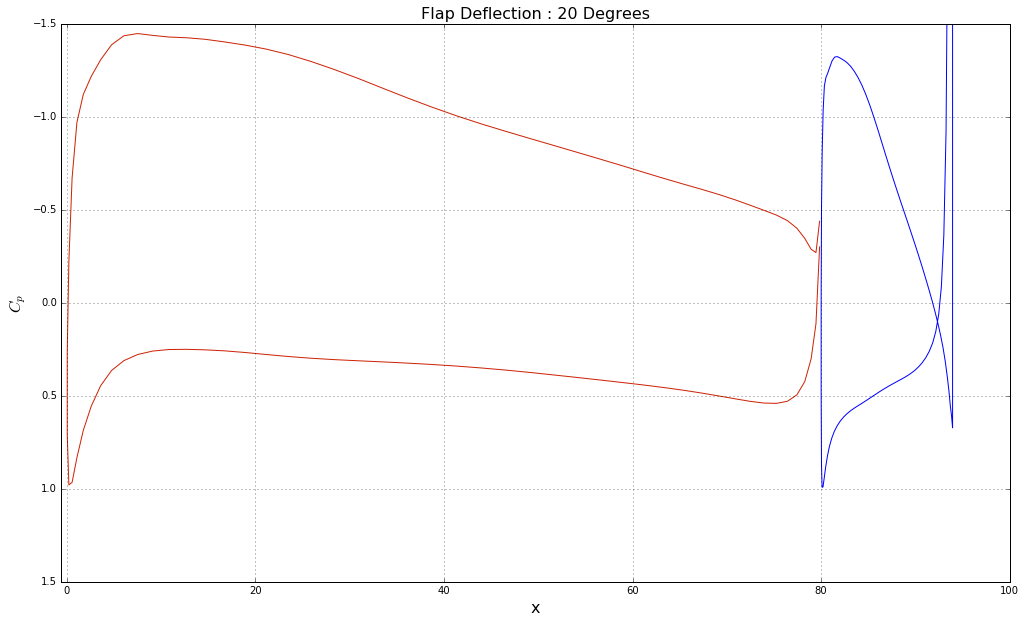

In [16]:
# plots the surface pressure coefficient
pyplot.figure(figsize=(17,10))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([p.xc for p in panels[0:N_panels]], [p.cp for p in panels[0:N_panels]], color='#CD2305')
pyplot.plot([p.xc for p in panelsf[0:Nfpanels]], [p.cp for p in panelsf[0:Nfpanels]], color='b')
pyplot.title('Flap Deflection : %d Degrees' % delta, fontsize=16)
pyplot.xlim(-0.6, 100)
pyplot.ylim(-1.5, 1.5)
pyplot.gca().invert_yaxis();